<a href="https://colab.research.google.com/github/shadialameddin/tensor_decomposition/blob/master/tensor_decomposition_test.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

http://tensorly.org/stable/auto_examples/index.html#general-examples

https://github.com/tensorly/tensorly


Sparse backend

Kruskal-tensors have been renamed cp_tensors

Matrix-product-state has now been renamed tensor-train


In [ ]:
!pip install -U tensorly --quiet

In [1]:
import os 

In [2]:
if not os.path.exists('tensor_decomposition') and not os.path.isfile('TensorDecomp.py'):
    !git clone https://github.com/shadialameddin/tensor_decomposition.git --quiet

In [ ]:
%cd tensor_decomposition

In [48]:
from TensorDecomp import *
import matplotlib.pyplot as plt

list of available decomposition types:

decomp_list = ['svd', 'parafac', 'tucker', 'matrix_product_state', 'NMF','non_negative_parafac', 'clarkson_woodruff_transform']
#### The Error Handles

In [4]:
err_fro  = lambda  x, y : norm(x-y, ord='fro') / norm(x, ord='fro')
err_L1   = lambda  x, y : norm(x-y, ord=1) / norm(x, ord=1)
err_Linf = lambda  x, y : norm(x-y, ord=inf) / norm(x, ord=inf)
err_Spec = lambda  x, y : norm(x-y, ord=2) / norm(x, ord=2)
    
normL = [err_fro, err_L1, err_Linf, err_Spec]

### Scene Setup

In [42]:
ngp, d, N = 8192, 6, 64

tensor = np.random.rand(ngp, d, N)


# two derived matrices of the tensor (unfolding)
mat_repr1_tens = tensor.reshape(-1, N)
mat_repr2_tens = tensor.reshape(ngp,-1)

# a vector with appropriate dimension to perform operations
vec = np.random.rand(N)

# a matrix with appropriate dimensions to perform operations
someMatrix = np.random.rand(ngp, d)
someTensor = np.random.rand(ngp, d, d)

# SVD

In [43]:
svd_rank = 12
u, s, vt = svds(mat_repr1_tens, svd_rank)
print(u.shape,s.shape,vt.shape)

(49152, 12) (12,) (12, 64)


### Decomposition Time

In [7]:
n = 100
svdDecTime = timeit.timeit((lambda: svds(mat_repr1_tens, svd_rank)), number=n)/n
print("Average SVD Decomposition Time:\t", svdDecTime)

Average SVD Decomposition Time:	 0.38929744200000016


### Memory Saving

In [8]:
memSavSvd = (tensor.nbytes - sum(f.nbytes for f in [u,s,vt])) / tensor.nbytes
print(f"Memory saving with SVD using {svd_rank} Rank:\t", memSavSvd)

Memory saving with SVD using 12 Rank:	 0.8122520446777344


### Decomposition Error

In [9]:
mat_repr1_recons = u @ np.diag(s) @ vt
svdFro, svdL1, svdLinf, svdSpec = [error(mat_repr1_tens, mat_repr1_recons) for error in normL ]

print("Frobenius Norm of the SVD Decomposition Error:\t", svdFro)
print("L1 Norm of the SVD Decomposition Error:\t\t", svdL1)
print("L infinity Norm of the SVD Decomposition Error:\t", svdLinf)
print("Spectral Norm of the SVD Decomposition Error:\t", svdSpec)

Frobenius Norm of the SVD Decomposition Error:	 0.4481601177256201
L1 Norm of the SVD Decomposition Error:		 0.4740675254157709
L infinity Norm of the SVD Decomposition Error:	 0.43459116955957156
Spectral Norm of the SVD Decomposition Error:	 0.07324689396940556


### Tensor Operations

In [23]:
# tensor x some vector
tensVec = tensor@vec

# tensor x some matrix
tensMat = np.einsum('ilk,il->k', tensor, someMatrix, optimize='optimal')

# tensor x some other tensor x tensor
tensTenstens = np.einsum('ilk,ilm,imp->kp', tensor, someTensor, tensor, optimize='optimal')

# matrix representation of a tensor x some vector
matRepr1Vec = mat_repr1_tens@vec

# matrix representations of a tensor x some tensor x matrix representations of a tensor
matReprTensMatRepr = mat_repr1_tens.T @ blk_diag(someTensor) @ mat_repr1_tens

# matrix representation of tensor x some matrix
matRepr1Mat = mat_repr1_tens.T@someMatrix.flatten()

(64, 64)


### Decomposed Tensor Operations

In [13]:
# svd of matrix representation of tensor x some vector
svdMatReprVec = u @ (np.diag(s) @ (vt @ vec))

# svd of matrix representation of tensor x some matrix
svdMatReprMat = vt.T @ np.diag(s) @ ( u.T @ someMatrix.flatten())


# svd of matrix representation of tensor x some Tensor x svd of matrix representation of tensor x some
svdMatReprTenssvdMatRepr = vt.T @ np.diag(s) @ ( u.T @ blk_diag(someTensor) @ u) @ np.diag(s) @ vt

(64,)


### Error between decomposed tensor - matrix and tensor-matrix operations

In [26]:
svdDecVec_fro, svdDecVec_L1, svdDecVec_Linf, svdDecVec_L2 = [norm(tensVec,svdMatReprVec.reshape(tensVec.shape)) for norm in normL]
print(svdDecVec_fro, svdDecVec_L1, svdDecVec_Linf, svdDecVec_L2)

tensMat_svdMatReprMat_L2 = err_Spec(tensMat,svdMatReprMat)
print(tensMat_svdMatReprMat_L2)

svdMatReprTenssvdMatRepr_tensTenstens_fro, svdMatReprTenssvdMatRepr_tensTenstens_L1, svdMatReprTenssvdMatRepr_tensTenstens_Linf, svdMatReprTenssvdMatRepr_tensTenstens_L2 = [norm(tensTenstens,svdMatReprTenssvdMatRepr) for norm in normL]
print(svdMatReprTenssvdMatRepr_tensTenstens_fro, svdMatReprTenssvdMatRepr_tensTenstens_L1, svdMatReprTenssvdMatRepr_tensTenstens_Linf, svdMatReprTenssvdMatRepr_tensTenstens_L2)

0.03908116534563884 0.031788768829652855 0.07417518539277848 0.016330372636707058
0.0011213854601963323
0.006228679082287276 0.003394950220372838 0.0034542681395328483 0.0010850751796630952


### Decomposition Speed Up Measures in Tensor Operations

In [29]:
n=100

# time of tensor x some vector
time_tensVec = timeit.timeit( lambda: tensor@vec, number = n)/n

# time of tensor x some matrix
time_tensMat = timeit.timeit( lambda:np.einsum('ilk,il->k', tensor, someMatrix, optimize='optimal'), number = n)/n

# time of tensor x some other tensor x tensor
time_tensTenstens = timeit.timeit( lambda:np.einsum('ilk,ilm,imp->kp', tensor, someTensor, tensor, optimize='optimal'), number = n)/n

# time of matrix representation of a tensor x some vector
time_matRepr1Vec = timeit.timeit( lambda:mat_repr1_tens@vec, number = n)/n

# time of matrix representations of a tensor x some tensor x matrix representations of a tensor
time_matReprTensMatRepr = timeit.timeit( lambda:mat_repr1_tens.T @ blk_diag(someTensor) @ mat_repr1_tens, number = n)/n

# time of matrix representation of tensor x some matrix
time_matRepr1Mat = timeit.timeit( lambda:mat_repr1_tens.T@someMatrix.flatten(), number = n)/n

# time of svd of matrix representation of tensor x some vector
time_svdMatReprVec = timeit.timeit( lambda:u @ (np.diag(s) @ (vt @ vec)), number = n)/n

# time of svd of matrix representation of tensor x some matrix
time_svdMatReprMat = timeit.timeit( lambda:vt.T @ np.diag(s) @ ( u.T @ someMatrix.flatten()), number = n)/n

# time of svd of matrix representation of tensor x some Tensor x svd of matrix representation of tensor x some
time_svdMatReprTenssvdMatRepr = timeit.timeit( lambda:vt.T @ np.diag(s) @ ( u.T @ blk_diag(someTensor) @ u) @ np.diag(s) @ vt, number = n)/n

In [40]:
# Speed up in operations

### 
speedup_tensVec_matReprVec = time_tensVec / time_matRepr1Vec
speedup_matRepr1Vec_svdMatReprVec =  time_matRepr1Vec / time_svdMatReprVec
speedup_tensVec_svdMatReprVec = time_tensVec / time_svdMatReprVec

###
speedup_tensMat_matRepr1Mat = time_tensMat / time_matRepr1Mat
speedup_matRepr1Mat_svdMatReprMat = time_matRepr1Mat / time_svdMatReprMat
speedup_tensMat_svdMatReprMat = time_tensMat / time_svdMatReprMat

###
speedup_tenstenstens_matReprTensMatRepr = time_tensTenstens / time_matReprTensMatRepr
speedup_matReprTensMatRepr_svdMatReprTenssvdMatRepr = time_matReprTensMatRepr / time_svdMatReprTenssvdMatRepr 
speedup_tenstenstens_svdMatReprTenssvdMatRepr = time_tensTenstens / time_svdMatReprTenssvdMatRepr 

# Tucker Decomposition

In [47]:
rank_tucker = 
core, factors = tucker(tensor,(rank_tucker,rank_tucker,rank_tucker))

TypeError: __init__() missing 1 required positional argument: 'dtype'

In [ ]:
errTucker = errList(tensor, tucker, vecR, vecL, matR, matL, normL, rank=[128,64,6])
timeTucker = tensor.decomp_time
memSavTucker = tensor.memSaving

In [ ]:
errParafac = errList(tensor, parafac, vecR, vecL, matR, matL, normL, rank=384)
timeParafac = tensor.decomp_time
memSavParafac = tensor.memSaving

In [7]:
errTT  = errList(tensor, matrix_product_state, vecR, vecL, matR, matL, normL, rank=[1,128,128,1])
timeTT = tensor.decomp_time
memSavTT = tensor.memSaving

In [8]:
errNNP  = errList(tensor, non_negative_parafac, vecR, vecL, matR, matL, normL, rank= 384)
timeNNP = tensor.decomp_time
memSavNNP = tensor.memSaving

Text(0, 0.5, 'Memory Saving [-]')

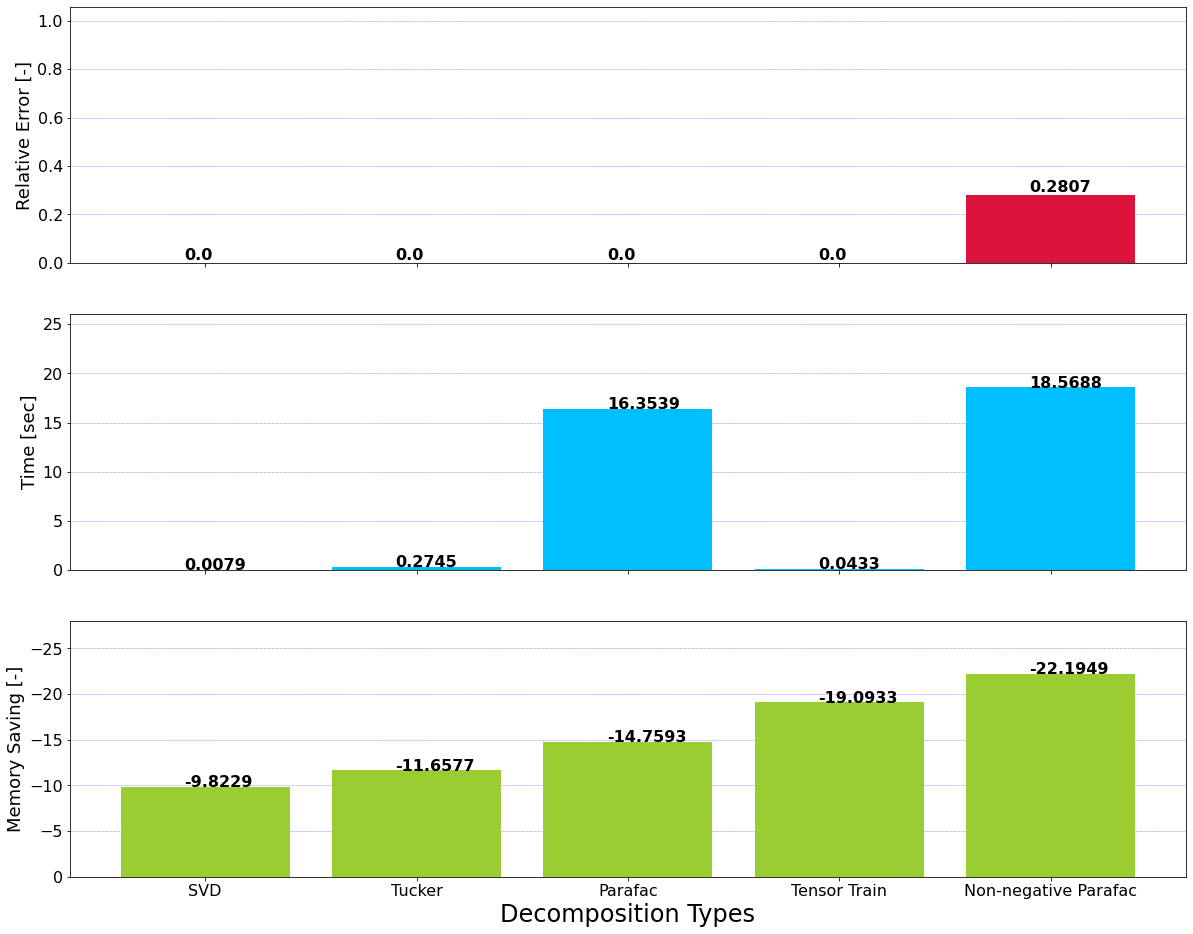

In [9]:
%matplotlib inline

xAxis = ['SVD', 'Tucker', 'Parafac', 'Tensor Train', 'Non-negative Parafac']
y0Axis = [errSvd[0][0], errTucker[0][0], errParafac[0][0], errTT[0][0], errNNP[0][0]]
y1Axis = [timeSvd, timeTucker, timeParafac, timeTT, timeNNP]
y2Axis = [memSavSvd, memSavTucker, memSavParafac, memSavTT, memSavNNP]
colors = ["crimson","deepskyblue", "yellowgreen"]

fig, ax = plt.subplots(3, 1, figsize=(20,16), sharex=True)
for i in range(3):
    ax[i].bar(xAxis, eval('y'+str(i)+'Axis'), color=colors[i])
    ax[i].yaxis.grid(color='b', alpha=0.5, linestyle='dashed', linewidth=0.5)
    ax[i].set_axisbelow(True)
    ax[i].set_ylim(0, np.ceil(max(eval('y'+str(i)+'Axis'))) + np.mean(eval('y'+str(i)+'Axis'))) if max(eval('y'+str(i)+'Axis')) > 0 else ax[i].set_ylim(0, np.floor(min(eval('y'+str(i)+'Axis')))-5)
    ax[i].tick_params(axis='both', which='major', labelsize=16)
    for h, v in enumerate(eval('y'+str(i)+'Axis')):
        ax[i].text(h-.10, v+.0125, str(np.round(v,4)), color='black', size = 16, weight = "bold")

plt.xlabel("Decomposition Types", fontsize=24)
ax[0].set_ylabel("Relative Error [-]", fontsize=18)
ax[1].set_ylabel("Time [sec]", fontsize=18)
ax[2].set_ylabel("Memory Saving [-]", fontsize=18)

In [10]:
operList = [lambda:tensor.tensor@vecR, lambda:vecL@tensor.tensor, lambda:tensor.tensor@matR, lambda:matL@tensor.tensor, lambda:vecL@tensor.tensor@vecR, 
lambda:matL@tensor.tensor@matR]

tensorOperationTimes = tensOpTim(operList)

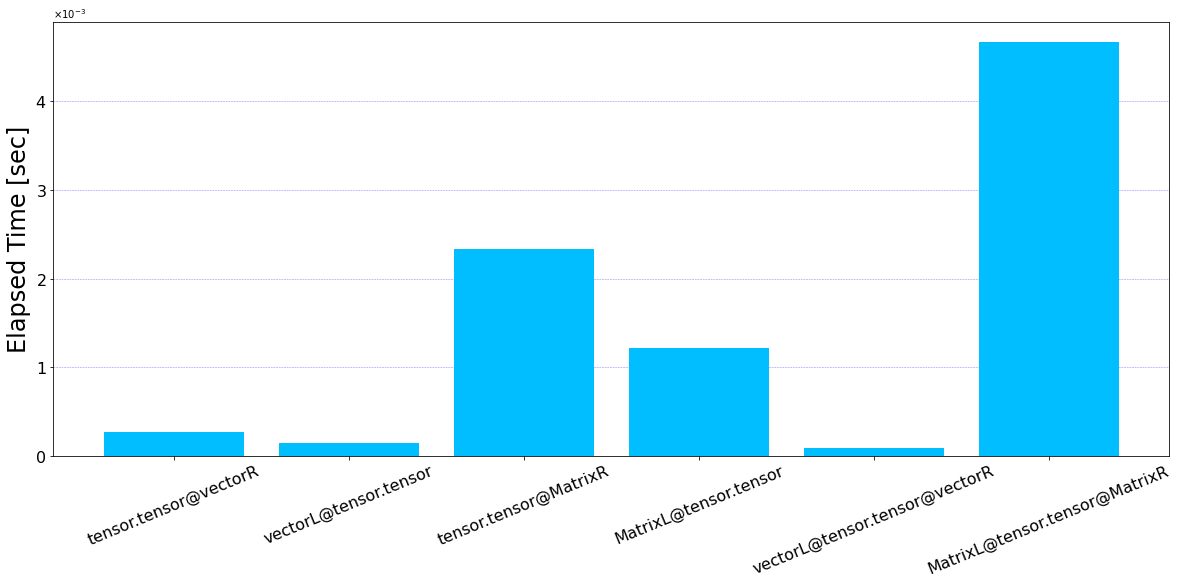

In [20]:
from matplotlib import ticker
uniSlightBlue = '#00BEFF'
fig, ax = plt.subplots(1, 1, figsize=(20,8))
ax.bar(operList, tensorOperationTimes, color = uniSlightBlue)
ax.yaxis.grid(color='b', alpha=0.5, linestyle='dashed', linewidth=0.5)
plt.xticks(rotation=22.5)
ax.set_axisbelow(True)
ax.set_ylabel("Elapsed Time [sec]", fontsize=24)
ax.tick_params(axis='both', which='major', labelsize=16)

formatter = ticker.ScalarFormatter(useMathText=True)
formatter.set_scientific(True) 
formatter.set_powerlimits((-1,1)) 
ax.yaxis.set_major_formatter(formatter) 

In [1]:
#TODO #1
# Speed comparion is not implemented. No function definition is defined for decomposed_tensor @ Vec multiplication.

In [2]:
#TODO #2
# For every decomposition type -> Line Plot: decomposition error, speedup time in tensor operations vs decomposed tensor operations.

In [4]:
# DONE! (11.07.21)
# For every decomposition type -> Bar plot: Decomposition error, decomposition time, memory saving